In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Parameters
kv_cache_dir = "kv_cache/crumb/nano-mistral/wikitext/fp32"  # Directory with KV cache files
output_dir = "cluster_results"  # Directory to save clustering results
os.makedirs(output_dir, exist_ok=True)

page_size = 16  # Maximum number of tokens per cluster
beta = 0.5  # Weight for temporal similarity
alpha = 0.1  # Temporal decay factor
num_tokens_to_process = 100  # Limit the number of tokens to process for efficiency

def load_kv_cache(layer_idx):
    """Load KV cache for a specific layer."""
    kv_file = os.path.join(kv_cache_dir, f"kv_cache_layer_{layer_idx}.pkl")
    if not os.path.exists(kv_file):
        raise FileNotFoundError(f"KV cache file for layer {layer_idx} not found: {kv_file}")
    
    print(f"Loading KV cache from {kv_file}...")
    with open(kv_file, "rb") as f:
        kv_cache = pickle.load(f)
    return kv_cache

def pad_to_match(arrays):
    """Pad arrays to match dimensions along the concatenation axis."""
    max_dim = max(a.shape[2] for a in arrays)  # Find the maximum size along the mismatched axis
    print(f"Padding arrays to match dimension: max_dim={max_dim}")
    padded_arrays = []
    for array in arrays:
        pad_width = [(0, 0)] * array.ndim
        pad_width = [(0, 0)] * array.ndim
        pad_width[2] = (0, max_dim - array.shape[2])  # Pad only the mismatched axis
        padded_arrays.append(np.pad(array, pad_width, mode='constant'))
    return np.concatenate(padded_arrays, axis=0)

def pad_selected(arrays, min_limit = 50, pad_or_neglect = "neglect"):
    padded_arrays = []
    for array in arrays:
        if array.shape[2]<min_limit:
            if pad_or_neglect == "neglect":
                pass
            else:
                pad_width = [(0, 0)] * array.ndim
                pad_width[2] = (0, min_limit- array.shape[2])  # Pad only the mismatched axis
                padded_arrays.append(np.pad(array, pad_width, mode='constant'))
        else:
            padded_arrays.append(array[:,:,:min_limit,:])
            
    return np.concatenate(padded_arrays, axis=0)
            
def compute_temporal_similarity(t1, t2):
    """Compute temporal similarity based on token indices."""
    return np.exp(-alpha * abs(t1 - t2))

def perform_clustering_with_similarities(layer_idx, kv_cache_v, beta, page_size, num_tokens_to_process):
    """Cluster tokens and calculate similarities for each pair within clusters."""

    keys = pad_selected(kv_cache_v, min_limit = 50, pad_or_neglect = "neglect")
    # flatten the axis 1 and 2 of 4 axis keys tensor
    print(keys.shape)
    keys = keys.reshape(-1, keys.shape[-1])
    print(keys.shape)
    
    # Compute semantic similarity (cosine similarity)
    print("Calculating semantic similarity...")
    semantic_sim = cosine_similarity(keys)

    # Initialize hybrid similarity matrix
    hybrid_sim = np.zeros_like(semantic_sim)
    for i in range(hybrid_sim.shape[0]):
        for j in range(hybrid_sim.shape[1]):
            temporal_sim = compute_temporal_similarity(i, j)
            hybrid_sim[i, j] = beta * temporal_sim + (1 - beta) * semantic_sim[i, j]

    num_tokens = keys.shape[0]
    
    # Clustering
    clusters = []
    visited = set()
    cluster_results = []

    while len(visited) < num_tokens:
        # Start a new cluster
        cluster = []
        remaining = set(range(num_tokens)) - visited

        # Start with the token that has the highest pairwise similarity
        seed_token = max(remaining, key=lambda x: sum(hybrid_sim[x, list(remaining)]))
        cluster.append(seed_token)
        visited.add(seed_token)

        # Add tokens with high hybrid similarity to the cluster
        for _ in range(page_size - 1):
            remaining = set(range(num_tokens)) - visited
            if not remaining:
                break

            # Find the token with the highest similarity to the current cluster
            next_token = max(remaining, key=lambda x: sum(hybrid_sim[x, cluster]))
            cluster.append(next_token)
            visited.add(next_token)

        clusters.append(cluster)

        # Collect similarities for the cluster
        for idx1 in cluster:
            for idx2 in cluster:
                if idx1 == idx2:
                    continue  # Skip self-comparisons
                cluster_results.append({
                    "layer": layer_idx,
                    "cluster_id": len(clusters) - 1,
                    "token1_idx": idx1,
                    "token2_idx": idx2,
                    "temporal_similarity": compute_temporal_similarity(idx1, idx2),
                    "semantic_similarity": semantic_sim[idx1, idx2],
                    "hybrid_similarity": hybrid_sim[idx1, idx2],
                })

    return cluster_results, hybrid_sim, clusters


In [ ]:
def cache_squeeze(clusters, KV_cache):
     
    pass

def cache_unsqueeze():
    pass

SyntaxError: incomplete input (3603594604.py, line 1)

In [ ]:
layer_idx = 3  # Layer index to process
try:
    print(f"Processing layer {layer_idx}...")
    kv_cache = load_kv_cache(layer_idx)
    sel_sample = [i for i,k in enumerate(kv_cache["keys"]) if k.shape[2]>50]
    print(sel_sample)
    selected_sample = kv_cache["keys"][sel_sample[random.randint(0,len(sel_sample)-1)]]
    cluster_results, sim, clusters = perform_clustering_with_similarities(layer_idx, [selected_sample], beta, page_size, num_tokens_to_process)
    
    cluster_df = pd.DataFrame(cluster_results)
except Exception as e:
    print(f"Error processing layer {layer_idx}: {e}")

print("Clustering with similarity calculations completed.")

Processing layer 3...
Loading KV cache from kv_cache/crumb/nano-mistral/wikitext/fp32/kv_cache_layer_3.pkl...
[3, 4, 11, 12, 16, 17, 34, 35, 39, 43, 44, 45, 46, 47, 48, 49, 50, 54, 56, 57, 59, 63, 67, 68, 69, 70, 78, 79, 83, 84, 85, 89, 90, 92, 96, 97, 98, 99, 100, 101, 105, 106, 107, 111, 112, 118, 119, 120, 121, 125, 126, 130, 131, 135, 136, 140, 141, 142, 143, 147, 179, 180, 184, 185, 186, 187, 191, 192, 193, 197, 198, 202, 203, 204, 205, 206, 210, 211, 215, 219, 223, 227, 231, 232, 233, 237, 238, 245, 249, 250, 251, 252, 256, 257, 258, 259, 260, 261, 266, 267, 271, 272, 276, 277, 278, 279, 280, 284, 285, 286, 287, 288, 292, 297, 298, 299, 303, 304, 308, 309, 310, 311, 312, 313, 314, 319, 324, 325, 326, 333, 334, 338, 339, 343, 344, 345, 349, 350, 351, 352, 353, 357, 358, 359, 360, 361, 362, 363, 364, 365, 369, 370, 371, 372, 373, 374, 378, 379, 380, 381, 385, 386, 387, 388, 392, 393, 394, 398, 399, 400, 401, 402, 403, 404, 408, 409, 410, 411, 415, 416, 417, 421, 422, 423, 424, 425,

In [55]:
#flatten a list of lists
pd.Series([item for sublist in clusters for item in sublist]).value_counts().sort_values()

116    1
115    1
117    1
118    1
119    1
      ..
148    1
19     1
17     1
99     1
82     1
Name: count, Length: 150, dtype: int64

In [56]:
cluster_df.head()

,layer,cluster_id,token1_idx,token2_idx,temporal_similarity,semantic_similarity,hybrid_similarity
0,3,0,116,115,0.904837,0.899045,0.901941
1,3,0,116,117,0.904837,0.893711,0.899274
2,3,0,116,118,0.818731,0.921350,0.870040
3,3,0,116,119,0.740818,0.874763,0.807791
4,3,0,116,114,0.818731,0.833706,0.826218


In [57]:
cluster_df["cluster_id"].value_counts()

cluster_id
0    240
1    240
2    240
3    240
4    240
5    240
6    240
7    240
8    240
9     30
Name: count, dtype: int64

In [58]:
group_matrix = np.zeros_like(sim)-1
for row_idx in cluster_df.index:
    row = cluster_df.loc[row_idx]
    group_matrix[int(row["token1_idx"]),int(row["token2_idx"])] = int(row["cluster_id"])
    


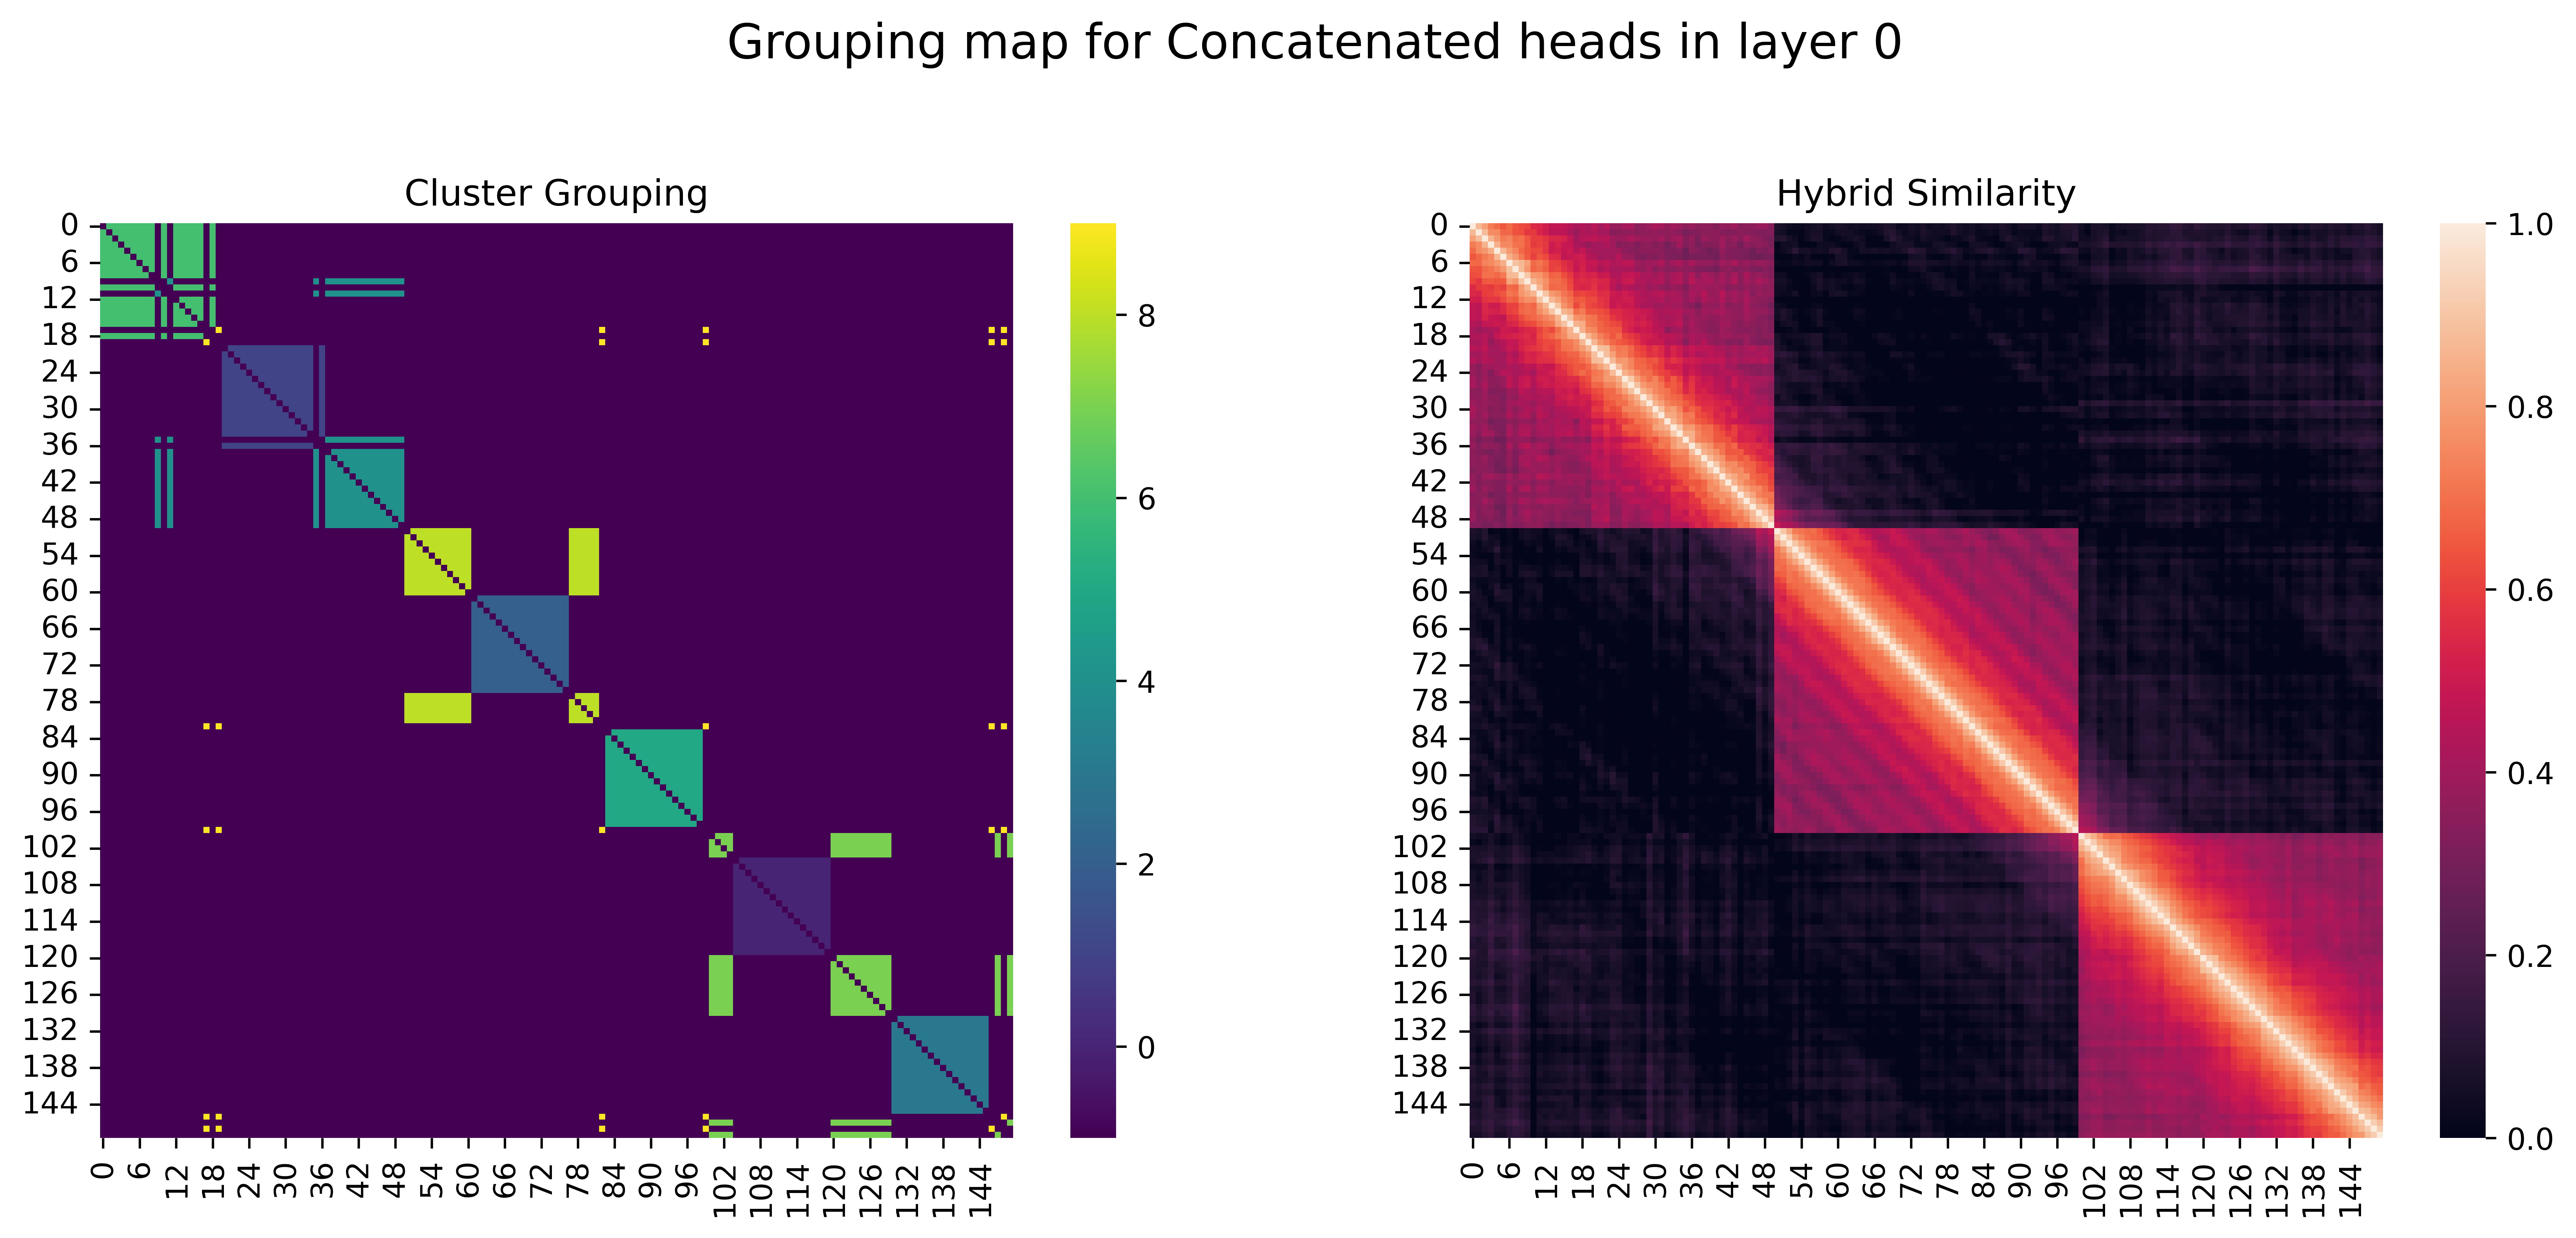

In [64]:
# plot 3 similarity matrices 
import matplotlib.pyplot as plt
import seaborn as sns

def plot_group_maps(i, layer_idx, group_matrix, sim_matrix):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5.5), dpi=600)
    fig.suptitle('Grouping map for Concatenated heads in layer {}'.format(i,layer_idx), fontsize=16, y=1.05)
    sns.heatmap(group_matrix, ax=ax[0], cmap="viridis")
    ax[0].set_title('Cluster Grouping')
    sns.heatmap(sim_matrix, ax=ax[1], vmin=0, vmax=1)
    ax[1].set_title('Hybrid Similarity')

    plt.show()

plot_group_maps(0, 3, group_matrix, sim)